# Rethinking Statistics course in NumPyro - Week 1

Lecture 1: The Golem of Prague

- [Video](https://www.youtube.com/watch?v=4WVelCswXo4)
- [Slides](https://speakerdeck.com/rmcelreath/l01-statistical-rethinking-winter-2019)

Lecture 2: Garden of Forking Data

- [Video](https://www.youtube.com/watch?v=XoVtOAN0htU)
- [Slides](https://speakerdeck.com/rmcelreath/l02-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week01.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week01_solutions.pdf) for the exercises of the week.

In [26]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

import os

import arviz as az

import jax.numpy as jnp
from jax import random, vmap
import jax

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use(["arviz-white", 'arviz-cyanish'])
numpyro.set_platform("cpu")

In [3]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Nov 17 2023

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.17.2

jax       : 0.4.19
numpyro   : 0.13.2
pandas    : 2.1.3
scipy     : 1.11.3
arviz     : 0.16.1
seaborn   : 0.12.2
numpy     : 1.26.2
matplotlib: 3.8.0

Watermark: 2.4.3



## Short Intro

In this short intro, I just play around a bit with the concepts of prior and posterior. I calculate manually both for the very simple glob tossing example mentioned in the lecture. You can jump to the actual homework going to the next section.

In [5]:
n=9    # tosses
k=6    # water
p=0.5  # water probability

How to generate binomials with `numpy`:

In [6]:
stats.binom.rvs(1, p, size=9)

array([1, 0, 0, 1, 1, 0, 0, 0, 0])

Density function of a binomial:

In [7]:
round(stats.binom.pmf(k, n, p), 2)

0.16

Example:

In [8]:
def posterior_grid_binomial(n, k, s):
    """Posterior sample of binomial distribution using grid integration.

    Args:
        n (int): trials
        k (int): successes
        s (int): probability grid discretization

    Returns:
        posteriors (ndarray): posterior probabilities
    """
    p_grid = np.linspace(0,1,s)
    priors = np.ones(s)
    likelihoods = stats.binom.pmf(k, n, p=p_grid)
    posteriors = priors * likelihoods
    posteriors = posteriors / sum(posteriors) # normalizing the posteriors
    return posteriors

In [9]:
n=9
k=6
s=50
posterior = posterior_grid_binomial(n, k, s)
sum(posterior)

0.9999999999999999

Looks good. Plotting the posterior:

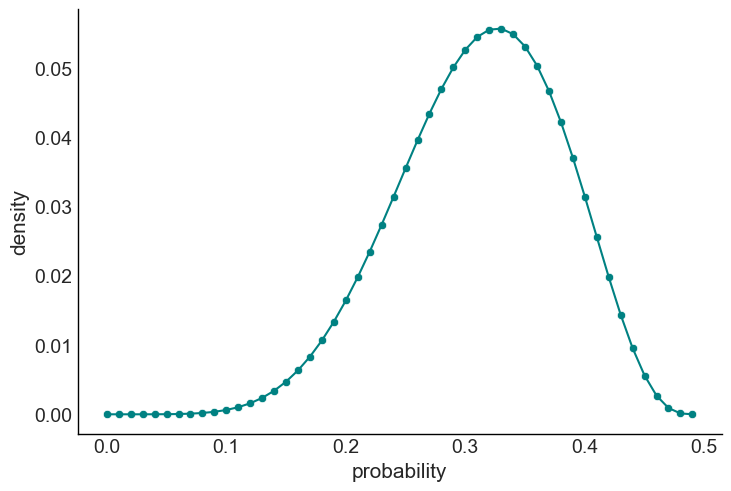

In [10]:
aux = pd.DataFrame(posterior).rename({0:'prob'}, axis=1)
aux['p'] = aux.index/100
g = sns.lineplot(data=aux, x='p', y='prob')
sns.scatterplot(data=aux, x='p', y='prob', ax=g)
g.set(xlabel='probability', ylabel='density');

Nice! Let's sample the posterior we just got:

In [12]:
p_grid = np.linspace(0,1,s)
samples = (pd.DataFrame(np.random.choice(p_grid, 5000, p=posterior))
            .reset_index()
            .rename({0:'prob'}, axis=1)
          )
samples.tail(3) # just to see how it looks

,index,prob
4997,4997,0.387755
4998,4998,0.653061
4999,4999,0.612245


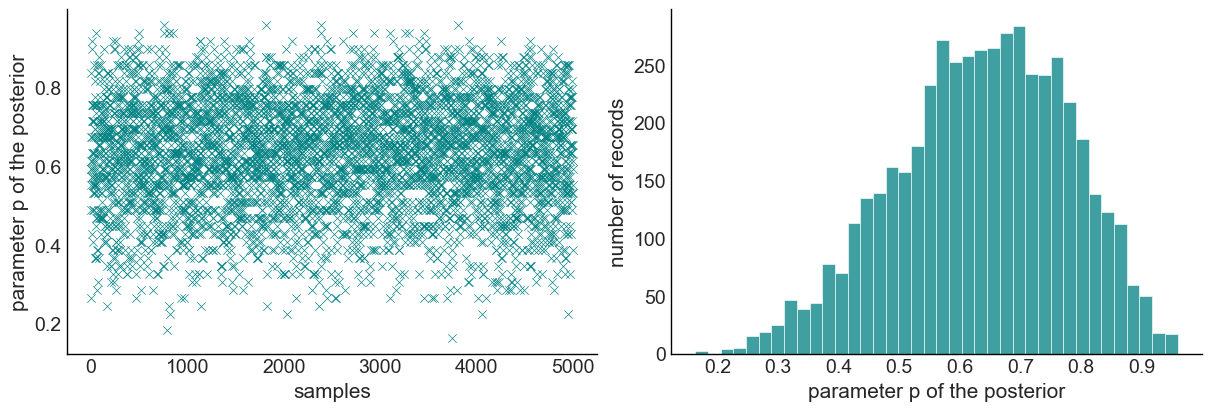

In [13]:
fig, axs = plt.subplots(ncols=2)
s = sns.scatterplot(data=samples, x='index', y='prob', marker='x', ax=axs[0])
s.set(xlabel='samples', ylabel='parameter p of the posterior')
h = sns.histplot(data=samples, x='prob', ax=axs[1])
h.set(xlabel='parameter p of the posterior', ylabel='number of records')
fig.set_size_inches(12,4)

You can think of the first plot as a bird view of the second one (shifted 90 degrees). Let's calculate the credible intervals.

In [14]:
round(np.percentile(samples.prob.values, 2.5),2), round(np.percentile(samples.prob.values, 97.5),2)

(0.35, 0.88)

## Chapter code

#### Code 2.1

Quickly computing plausabilities of these ways to produce data:

In [15]:
ways = jnp.array([0.0, 3, 8, 9, 0])
ways / jnp.sum(ways)

DeviceArray([0.  , 0.15, 0.4 , 0.45, 0.  ], dtype=float32)

#### Code 2.2

Compute the likelihood of the 6 W's in 9 tosses with the probability of water being 0.5:

In [16]:
jnp.exp(dist.Binomial(total_count=9, probs=0.5).log_prob(6))

DeviceArray(0.16406286, dtype=float32)

#### Code 2.3

Combine all steps together to perform the grid approximation for the Globe tossing model:

In [18]:
# define grid
p_grid = jnp.linspace(start=0, stop=1, num=20)

# define prior
prior = jnp.repeat(1, 20)

# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / jnp.sum(unstd_posterior)
posterior

DeviceArray([0.00000000e+00, 7.98983422e-07, 4.30771906e-05,
             4.09079512e-04, 1.89388858e-03, 5.87387104e-03,
             1.40429325e-02, 2.78517380e-02, 4.78011668e-02,
             7.28073940e-02, 9.98729467e-02, 1.24264345e-01,
             1.40314370e-01, 1.42834887e-01, 1.28943220e-01,
             9.98729467e-02, 6.20588921e-02, 2.64547691e-02,
             4.65966528e-03, 0.00000000e+00], dtype=float32)

#### Code 2.4

Plot the resulting posterior distribution:

/opt/anaconda3/envs/StatRethink/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


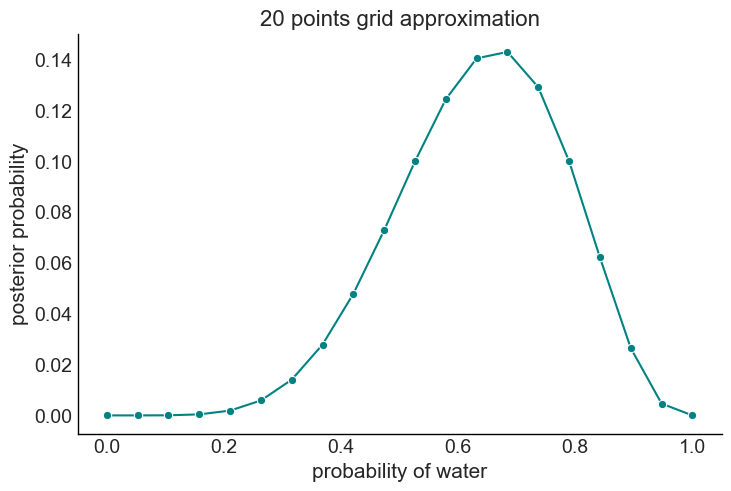

In [32]:
sns.lineplot(p_grid, posterior, marker='o')
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title("20 points grid approximation")
plt.show()

#### Code 2.5

Now try the same with a different (non-flat) prior:

In [33]:
prior1 = jnp.where(p_grid < 0.5, 0, 1)
prior2 = jnp.exp(-5 * abs(p_grid - 0.5))

/opt/anaconda3/envs/StatRethink/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/StatRethink/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


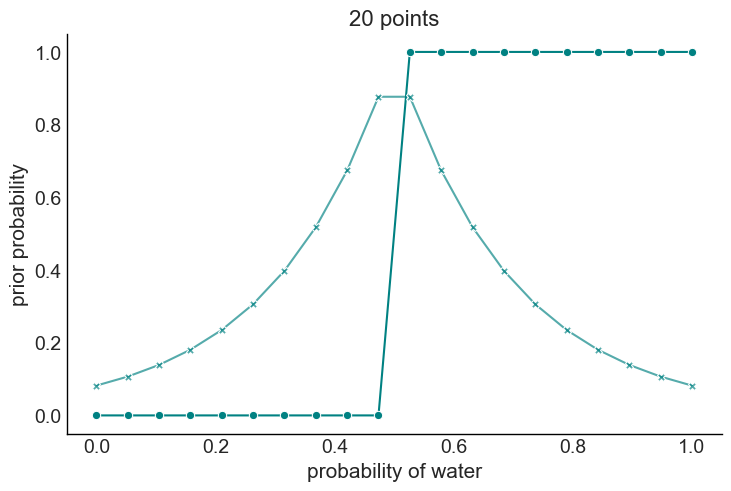

/opt/anaconda3/envs/StatRethink/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/StatRethink/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


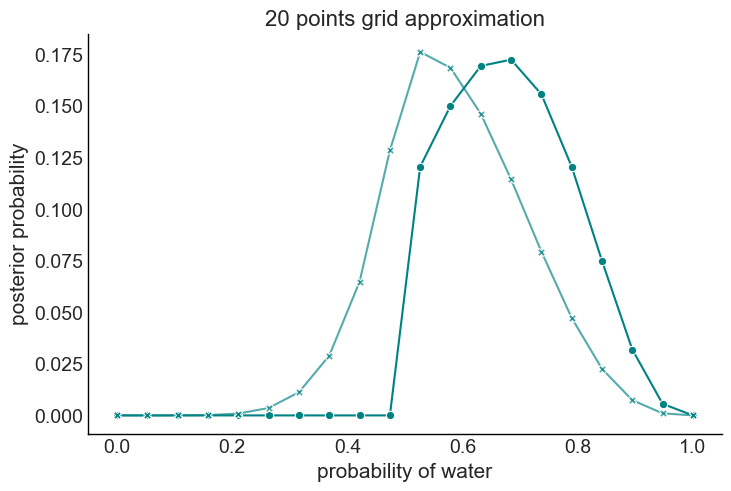

In [35]:
# compute product of likelihood and prior
unstd_posterior1 = likelihood * prior1
unstd_posterior2 = likelihood * prior2

# standardize the posterior, so it sums to 1
posterior1 = unstd_posterior1 / jnp.sum(unstd_posterior1)
posterior2 = unstd_posterior2 / jnp.sum(unstd_posterior2)

sns.lineplot(p_grid, prior1, marker='o')
sns.lineplot(p_grid, prior2, marker='X')
plt.xlabel("probability of water")
plt.ylabel("prior probability")
plt.title("20 points")
plt.show()

sns.lineplot(p_grid, posterior1, marker='o')
sns.lineplot(p_grid, posterior2, marker='X')
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title("20 points grid approximation")
plt.show()

#### Code 2.6
Let's now compute quadratic approximation for the Globe tossing model:

In [38]:
def model(W, L):
    p = numpyro.sample("p", dist.Uniform(0, 1))  # uniform prior
    numpyro.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood


guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), W=6, L=3)
svi_result = svi.run(random.PRNGKey(0), 1000)
params = svi_result.params

# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
numpyro.diagnostics.print_summary(samples, prob=0.89, group_by_chain=False)

100%|██████████| 1000/1000 [00:00<00:00, 2475.09it/s, init loss: 2.9278, avg. loss [951-1000]: 2.7795]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         p      0.62      0.14      0.63      0.41      0.84    845.27      1.00



#### Code 2.7
Let's compare the approximation above to the exact calculation of the posterior:

/opt/anaconda3/envs/StatRethink/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/StatRethink/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


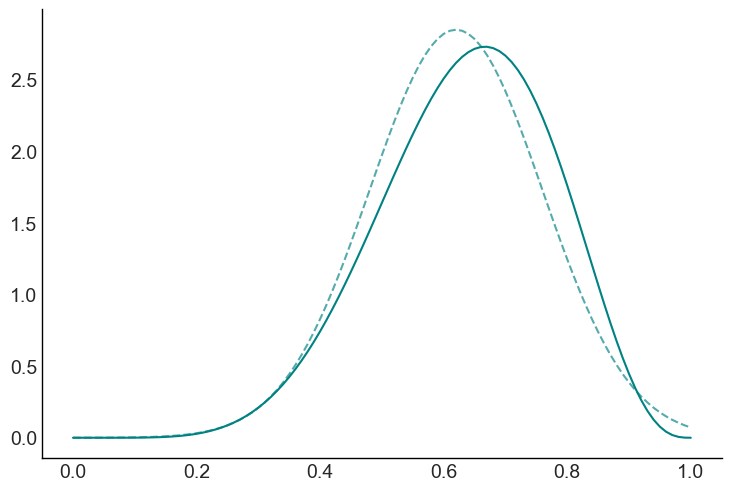

In [48]:
# analytical calculation
W = 6
L = 3
x = jnp.linspace(0, 1, 101)
sns.lineplot(x, jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)))
# quadratic approximation
sns.lineplot(x, jnp.exp(dist.Normal(0.62, 0.14).log_prob(x)), linestyle="--")
plt.show()

#### Code 2.8
Let's finally try MCMC:

In [49]:
n_samples = 1000
p = [jnp.nan] * n_samples
p[0] = 0.5
W = 6
L = 3
with numpyro.handlers.seed(rng_seed=0):
    for i in range(1, n_samples):
        p_new = numpyro.sample("p_new", dist.Normal(p[i - 1], 0.1))
        p_new = jnp.abs(p_new) if p_new < 0 else p_new
        p_new = 2 - p_new if p_new > 1 else p_new
        q0 = jnp.exp(dist.Binomial(W + L, p[i - 1]).log_prob(W))
        q1 = jnp.exp(dist.Binomial(W + L, p_new).log_prob(W))
        u = numpyro.sample("u", dist.Uniform())
        p[i] = p_new if u < q1 / q0 else p[i - 1]

#### Code 2.9
And let's plot the results:

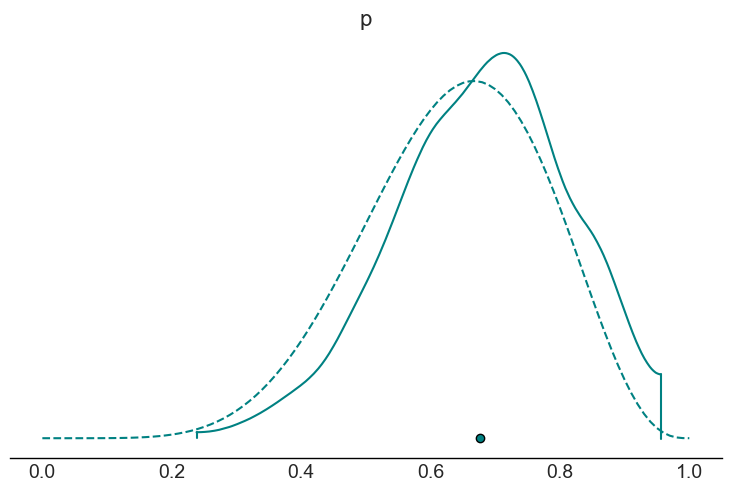

In [51]:
az.plot_density({"p": p}, hdi_prob=1)
sns.lineplot(x=x, y=jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)), linestyle="--")
plt.show()

#### Code 3.1
How to do basic calculations:

In [52]:
Pr_Positive_Vampire = 0.95
Pr_Positive_Mortal = 0.01
Pr_Vampire = 0.001
tmp = Pr_Positive_Vampire * Pr_Vampire
Pr_Positive = tmp + Pr_Positive_Mortal * (1 - Pr_Vampire)
Pr_Vampire_Positive = tmp / Pr_Positive
Pr_Vampire_Positive

0.08683729433272395

#### Code 3.2
Let's remind ourselves how to compute posterior using grid approximation:

In [53]:
p_grid = jnp.linspace(start=0, stop=1, num=1000)
prob_p = jnp.repeat(1, 1000)
prob_data = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))
posterior = prob_data * prob_p
posterior = posterior / jnp.sum(posterior)

#### Code 3.3
Now let's draw 10000 samples from this posterior (parameter values with posterior probability of being drawn):

In [54]:
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (10000,))]

#### Code 3.4
Let's plot the samples:

/opt/anaconda3/envs/StatRethink/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


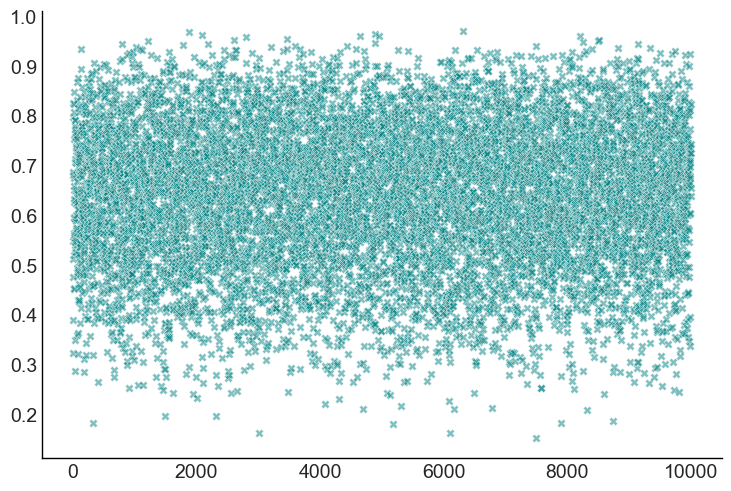

In [57]:
sns.scatterplot(range(len(samples)), samples, marker='X', alpha=.5)
plt.show()

#### Code 3.5
Let's now plot density estimate of these samples:

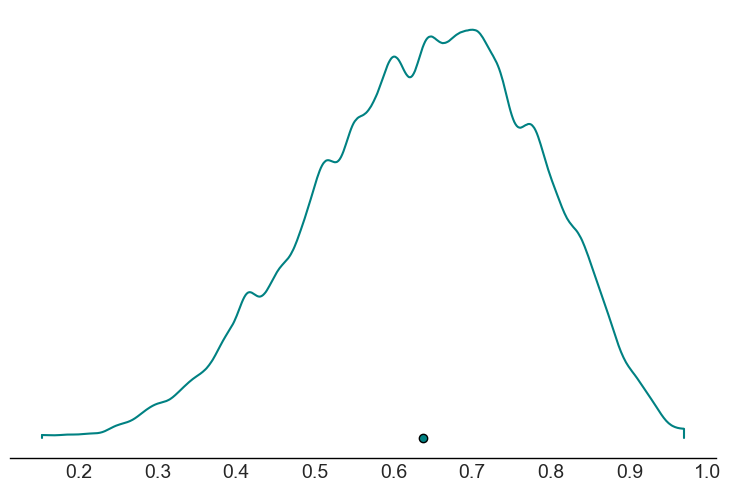

In [58]:
az.plot_density({"": samples}, hdi_prob=1)
plt.show()

#### Code 3.6
Let's calculate the posterior probability of the proportion of water being less than 0.5:

In [59]:
# add up posterior probability where p < 0.5
jnp.sum(posterior[p_grid < 0.5])

DeviceArray(0.17187458, dtype=float32)

#### Code 3.7
Let's do the same but using samples, not the grid approximation:

In [61]:
jnp.sum(samples < 0.5) / 1e4

DeviceArray(0.1711, dtype=float32, weak_type=True)

#### Code 3.8
Now we can do the same for the water proportion lying between 0.5 and 0.75:

In [62]:
jnp.sum((samples > 0.5) & (samples < 0.75)) / 1e4

DeviceArray(0.6025, dtype=float32, weak_type=True)

#### Code 3.9
We can also compute a quantile i.e. the parameter value for which 80% of the posterior probability lies to the left:

In [63]:
jnp.quantile(samples, 0.8)


DeviceArray(0.7637637, dtype=float32)

#### Code 3.10
The boundaries of 10 and 90% quantiles can also be found:

In [64]:
jnp.quantile(samples, jnp.array([0.1, 0.9]))


DeviceArray([0.44644645, 0.8168168 ], dtype=float32)

#### Code 3.11
Let's now compute a different highly skewed posterior using grid approximation:

In [65]:
p_grid = jnp.linspace(start=0, stop=1, num=1000)
prior = jnp.repeat(1, 1000)
likelihood = jnp.exp(dist.Binomial(total_count=3, probs=p_grid).log_prob(3))
posterior = likelihood * prior
posterior = posterior / jnp.sum(posterior)
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (10000,))]

#### Code 3.12
Now let's compute 50% percentile for this distribution:

In [66]:
jnp.percentile(samples, q=jnp.array([25, 75]))


DeviceArray([0.7077077, 0.9319319], dtype=float32)

#### Code 3.13
But a better representation of the posterior distribution would be HPDI:

In [67]:
numpyro.diagnostics.hpdi(samples, prob=0.5)

array([0.8418418, 0.998999 ], dtype=float32)

#### Code 3.14
Let's report the maximum a posteriori estimate:

In [68]:
p_grid[jnp.argmax(posterior)]


DeviceArray(1., dtype=float32)

#### Code 3.15
Or we can approximate the same value from the sample from posterior:

In [70]:
samples[jnp.argmax(stats.gaussian_kde(samples, bw_method=0.01)(samples))]

DeviceArray(0.988989, dtype=float32)

#### Code 3.16
In the same fashion, we can report the mean or the median:

In [71]:
print(jnp.mean(samples))
print(jnp.median(samples))

0.8011085
0.8428428


#### Code 3.17
Let's compute the average weighted loss for water proportion = 0.5:

In [72]:
jnp.sum(posterior * jnp.abs(0.5 - p_grid))


DeviceArray(0.31287518, dtype=float32)

#### Code 3.18
We can generalise it for every possible proportion on the grid:

In [76]:
loss = vmap(lambda d: jnp.sum(posterior * jnp.abs(d - p_grid)))(p_grid)

#### Code 3.19
Let's now find the parameter value that minimises the loss (will be close to the median of the samples):

In [77]:
p_grid[jnp.argmin(loss)]

DeviceArray(0.8408408, dtype=float32)

#### Code 3.20
We can compute the pobability of 0, 1, 2 W:

In [78]:
jnp.exp(dist.Binomial(total_count=2, probs=0.7).log_prob(jnp.arange(3)))

DeviceArray([0.09000002, 0.41999984, 0.48999998], dtype=float32)

#### Code 3.21
And we can simulate observations from this distribution:

In [79]:
dist.Binomial(total_count=2, probs=0.7).sample(random.PRNGKey(0))

DeviceArray(1, dtype=int32)

#### Code 3.22
A set of 10 simulations can be obtained by running:

In [81]:
dist.Binomial(total_count=2, probs=0.7).sample(random.PRNGKey(2), (10,))

DeviceArray([2, 1, 2, 1, 1, 2, 2, 2, 2, 1], dtype=int32)

#### Code 3.23
Let's validate that the observations appear in proportion to their likelihood:

In [82]:
dummy_w = dist.Binomial(total_count=2, probs=0.7).sample(random.PRNGKey(0), (100000,))
jnp.unique(dummy_w, return_counts=True)[1] / 1e5

DeviceArray([0.0888 , 0.41789, 0.49331], dtype=float32, weak_type=True)

#### Code 3.24
Now let's simulate 9 tosses as before:

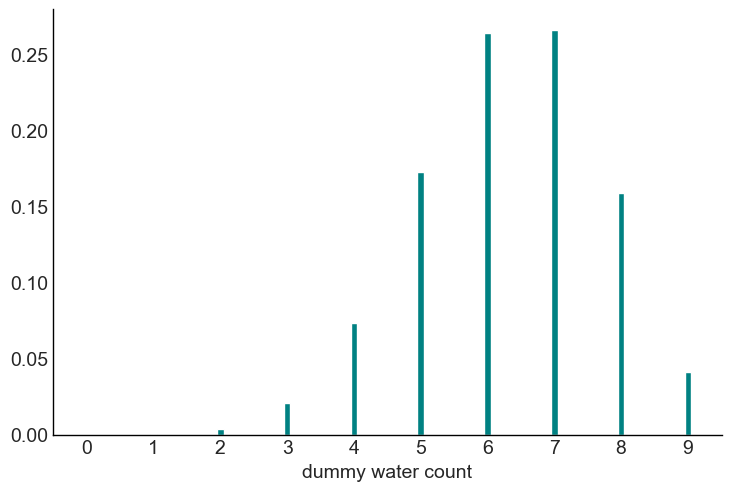

In [83]:
dummy_w = dist.Binomial(total_count=9, probs=0.7).sample(random.PRNGKey(0), (100000,))
ax = az.plot_dist(np.asarray(dummy_w), kind="hist", hist_kwargs={"rwidth": 0.1})
ax.set_xlabel("dummy water count", fontsize=14)
plt.show()

#### Code 3.25
Let's now calculate predictive posterior. First, let's prepare a sample:

In [84]:
w = dist.Binomial(total_count=9, probs=0.6).sample(random.PRNGKey(0), (int(1e4),))

#### Code 3.26
Now we replace the parameter value with this sample to propagate the uncertainty of the predictions:

In [85]:
w = dist.Binomial(total_count=9, probs=samples).sample(random.PRNGKey(0))


## Homework
### Easy

/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

<Axes: >

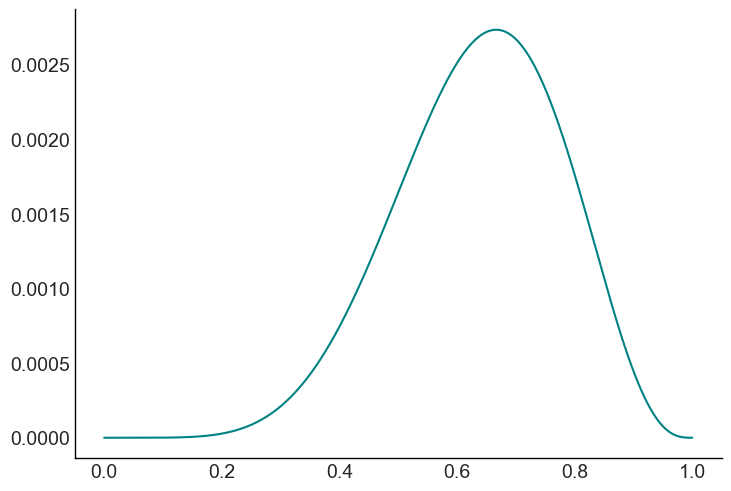

In [27]:
p_grid = jnp.linspace(start=0, stop=1, num=1000)
prior = jnp.repeat(1, 1000)
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))
posterior = likelihood * prior
posterior = posterior / jnp.sum(posterior)
samples = p_grid[dist.Categorical(posterior).sample(random.PRNGKey(100), (10000,))]

sns.lineplot(x=p_grid, y=posterior)

#### 3E1

In [18]:
print(jnp.sum(posterior[p_grid < 0.2]))
print(jnp.sum(samples < 0.2) / 1e4)

0.0008560951
0.001


#### 3E2

In [20]:
print(jnp.sum(posterior[p_grid > 0.8]))
print(jnp.sum(samples > 0.8) / 1e4)

0.12034492
0.121


#### 3E3

In [22]:
print(jnp.sum(posterior[(p_grid > 0.2) & (p_grid < 0.8)]))
print(jnp.sum((samples < 0.8) & (samples > 0.2)) / 1e4)

0.878799
0.878


#### 3E4

In [33]:
jnp.quantile(samples, 0.2)

Array(0.5185185, dtype=float32)

#### 3E5

In [34]:
jnp.quantile(samples, 0.8)

Array(0.7607607, dtype=float32)

#### 3E6

In [37]:
numpyro.diagnostics.hpdi(samples, prob=0.66)

array([0.5155155, 0.7847848], dtype=float32)

#### 3E7

In [38]:
jnp.quantile(samples, jnp.array([0.17, 0.83]))

Array([0.5023324, 0.7737738], dtype=float32)

### Medium
##### 3M1
>Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

<Axes: >

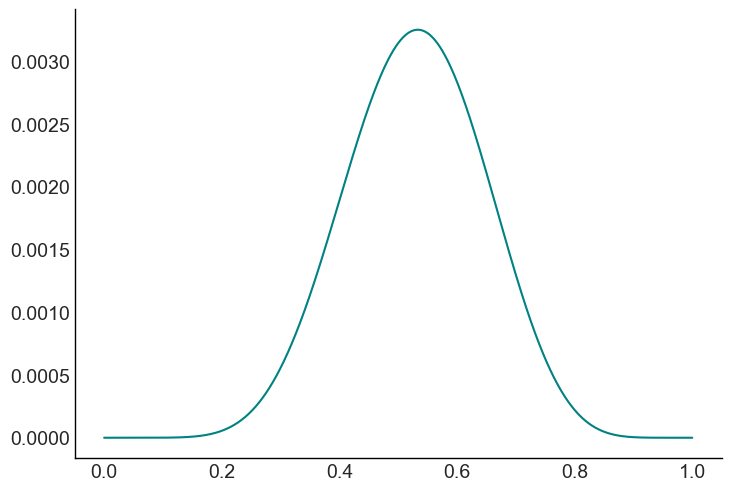

In [48]:
# define grid
p_grid = jnp.linspace(start=0, stop=1, num=1000)

# define prior
prior = jnp.repeat(1, 1000)

# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=15, probs=p_grid).log_prob(8))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / jnp.sum(unstd_posterior)

sns.lineplot(x=p_grid, y=posterior)

#### 3M2

In [49]:
samples = p_grid[dist.Categorical(posterior).sample(random.PRNGKey(100), (10000,))]
numpyro.diagnostics.hpdi(samples, 0.9)

array([0.33333334, 0.7187187 ], dtype=float32)

#### 3M3

/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


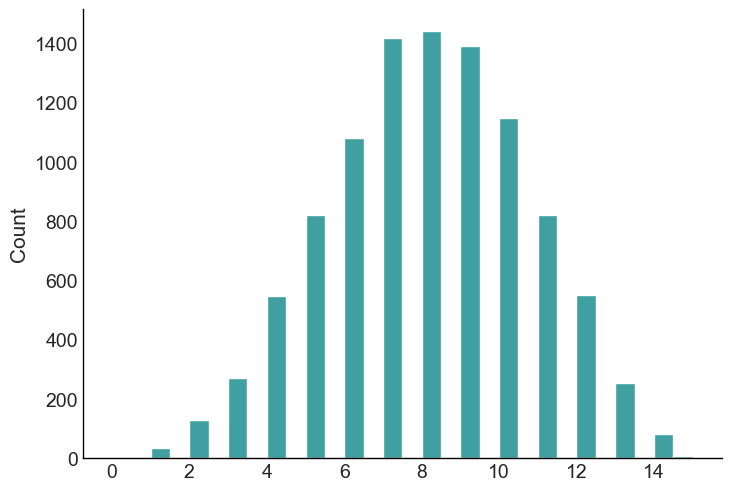

0 W prob: 0.0004
1 W prob: 0.0034
2 W prob: 0.0128
3 W prob: 0.0271
4 W prob: 0.0549
5 W prob: 0.082
6 W prob: 0.1082
7 W prob: 0.1417
8 W prob: 0.1443
9 W prob: 0.1392
10 W prob: 0.1147
11 W prob: 0.0821
12 W prob: 0.055
13 W prob: 0.0252
14 W prob: 0.0082
15 W prob: 0.0008


In [84]:
pred_posterior = dist.Binomial(total_count=15, probs=samples).sample(random.PRNGKey(0))
sns.histplot(pred_posterior, bins=30)
plt.show()
for i,k in zip(jnp.unique(pred_posterior, return_counts=True)[0], jnp.unique(pred_posterior, return_counts=True)[1] / len(samples)): 
    print(i, 'W prob:', k)


#### 3M4

/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

<Axes: >

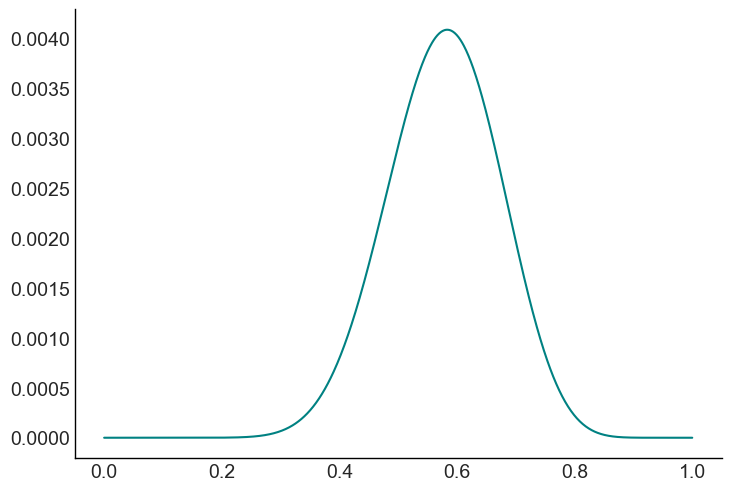

In [88]:
# define grid
p_grid = jnp.linspace(start=0, stop=1, num=1000)

# define prior
prior = posterior

# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))

# compute product of likelihood and prior
unstd_posterior_2 = likelihood * prior

# standardize the posterior, so it sums to 1
posterior_2 = unstd_posterior_2 / jnp.sum(unstd_posterior_2)

sns.lineplot(x=p_grid, y=posterior_2)

#### 3M5

/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

<Axes: >

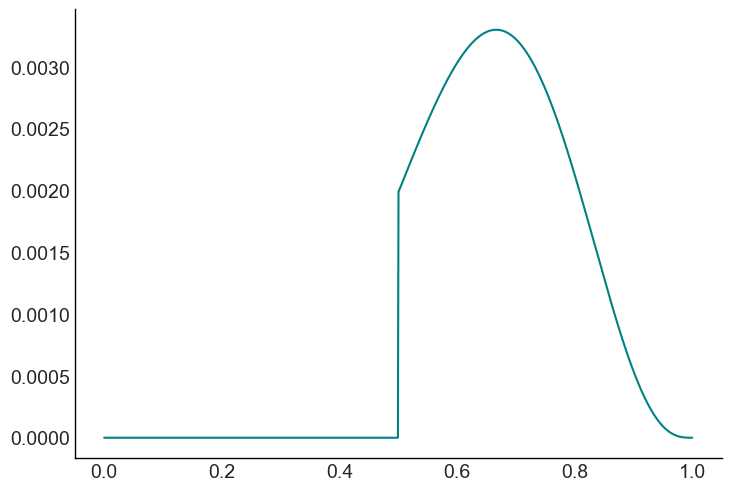

In [89]:
# define grid
p_grid = jnp.linspace(start=0, stop=1, num=1000)

# define prior
prior = jnp.where(p_grid < 0.5, 0, 1)

# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / jnp.sum(unstd_posterior)

sns.lineplot(x=p_grid, y=posterior)

With the impossible values less than 0.5 ruled out, the second model piles up more plausibility on the higher values near the true value. The data are
still misleading it to think that values just above 0.5 are the most plausible. But the posterior mean of 0.63 is much better than 0.53 from the previous
problem. Informative priors, when based on real scientific information, help. Here, the informative prior helps because there isn't much data. That is common in a lot of fields, ranging from astronomy to paleontology

#### 3M6

/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

0.0021496618
0.016748482
0.1614299
0.9971559


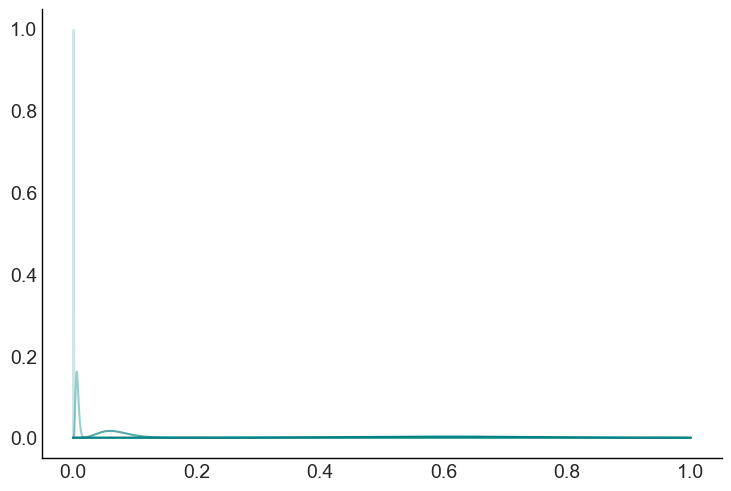

In [97]:
# define grid
p_grid = jnp.linspace(start=0, stop=1, num=1000)

# define prior
prior = jnp.repeat(1, 1000)

for n_tosses in jnp.array([10, 100, 1000, 10000]):
    # compute likelihood at each value in grid
    likelihood = jnp.exp(dist.Binomial(total_count=n_tosses, probs=p_grid).log_prob(6))

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / jnp.sum(unstd_posterior)
    
    PI = jnp.quantile(posterior, jnp.array([0.5, 99.5]))
    print(PI[1] - PI[0])
    sns.lineplot(x=p_grid, y=posterior)
    
plt.legend();

One way to approach this problem is to try a range of sample sizes and to plot the interval width of each. Here's some code to compute the posterior and get the interval width. There are other ways to compute the interval width. But the former is closest to the code in the book. Now since we want to do this for different values of $N$, it's nice to make this into a function. Now if you enter binomial_grid_posterior(20), you get an interval width for 20 globe tosses. Now notice that the interval width varies across simulations. As you increase N, this variation shrinks rapidly. This is because as the sample size increases, the differences between samples shrink. Now we need to run simulations across a bunch of different sample size to find where the interval shrinks to 0.05 in width.

In [22]:
p=0.7
s=1001
akk = []
for n in [100, 1000, 10000, 100000]:
    k=sum(np.random.binomial(1, p, n))
    p_grid_3 = np.linspace(0,1,s)
    posterior_3 = posterior_grid_binomial(n, k, s)
    samples = (pd.DataFrame(np.random.choice(p_grid_3, 5000, p=posterior_3))
               .reset_index()
               .rename({0:'prob'}, axis=1)
               .assign(n=n)
              )
    akk.append(samples)
    print(f'Distribution size: {n}, PI(0.5, 99.5): {np.round(np.quantile(samples.prob.values, 0.05), 3), np.round(np.quantile(samples.prob.values, 0.95), 3)}')
all_samples = pd.concat(akk).drop(['index'], axis=1)

Distribution size: 100, PI(0.5, 99.5): (0.589, 0.742)
Distribution size: 1000, PI(0.5, 99.5): (0.692, 0.739)
Distribution size: 10000, PI(0.5, 99.5): (0.7, 0.715)
Distribution size: 100000, PI(0.5, 99.5): (0.697, 0.702)


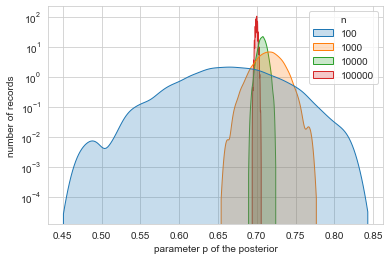

In [23]:
h = sns.kdeplot(data=all_samples, x='prob', hue='n', palette='tab10', shade=True)
h.set(xlabel='parameter p of the posterior', ylabel='number of records', yscale='log');

Looks like we need more than 2000 tosses of the globe to get the interval to be that precise. The above is a general feature of learning from data: The greatest returns on learning come early on. Each additional observation contributes less and less. So it takes very much effort to progressively reduce our uncertainty. So if your application requires a very precise estimate, be prepared to collect a lot of data. Or to change your approach.

### Hard

In [100]:
# fmt: off
birth1 = [
    1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
    0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
    1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
    0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
]
birth2 = [
    0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
    0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
    0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
]

homeworkch3 = pd.read_csv("data/homeworkch3.csv")
sum(birth1) + sum(birth2)


111

#### 3H1

0.5665666


/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

<Axes: >

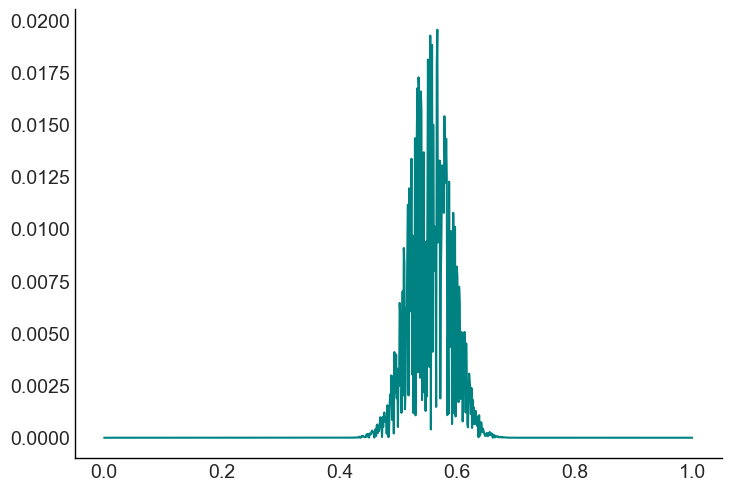

In [105]:
# define grid
p_grid = jnp.linspace(start=0, stop=1, num=1000)

# define prior
prior = dist.Uniform().sample(random.PRNGKey(100), (1000,))

# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=len(birth1) + len(birth2), probs=p_grid).log_prob(111))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / jnp.sum(unstd_posterior)

print(p_grid[jnp.argmax(posterior)])

sns.lineplot(x=p_grid, y=posterior)

#### 3H2

In [110]:
samples = p_grid[dist.Categorical(posterior).sample(random.PRNGKey(100), (10000,))]

print("50% HPDI:", numpyro.diagnostics.hpdi(samples, 0.5))
print("89% HPDI:", numpyro.diagnostics.hpdi(samples, 0.89))
print("97% HPDI:", numpyro.diagnostics.hpdi(samples, 0.97))

50% HPDI: [0.5345345 0.5805806]
89% HPDI: [0.5015015 0.6086086]
97% HPDI: [0.47947946 0.6286286 ]


#### 3H3

100


/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

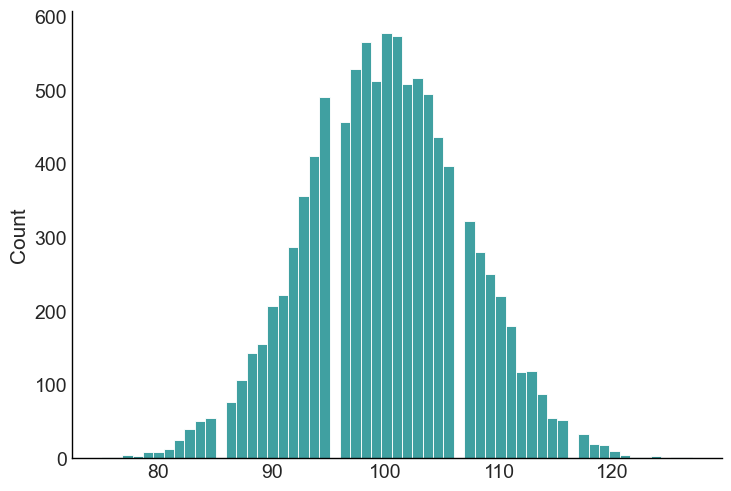

In [135]:
sample = dist.Binomial(total_count=200, probs=0.5).sample(random.PRNGKey(100), (10000,))
counts = jnp.unique(sample, return_counts=True)

print(counts[0][jnp.argmax(counts[1])])

sns.histplot(sample)

#### 3H4

51
50


/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

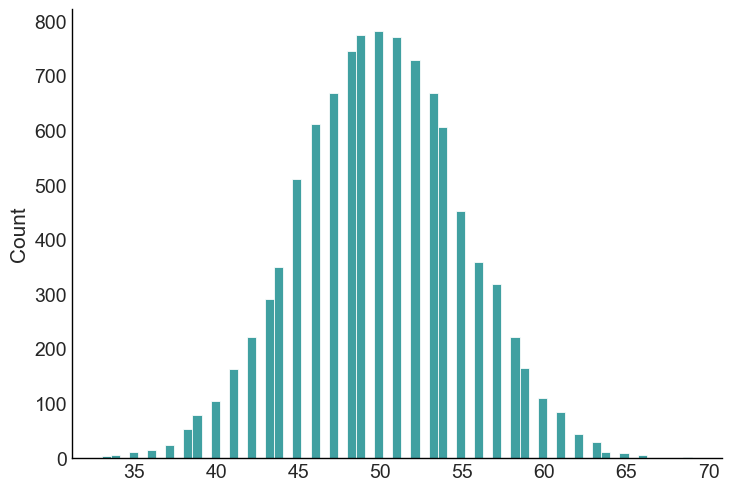

In [138]:
sample = dist.Binomial(total_count=100, probs=0.5).sample(random.PRNGKey(100), (10000,))
counts = jnp.unique(sample, return_counts=True)

print(np.sum(birth1))
print(counts[0][jnp.argmax(counts[1])])

sns.histplot(sample)

#### 3H5

In [142]:
boys_after_female = jnp.sum(jnp.array(birth2)[jnp.where(jnp.array(birth1) == 0)])
boys_after_female

Array(39, dtype=int32)

39
25


/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

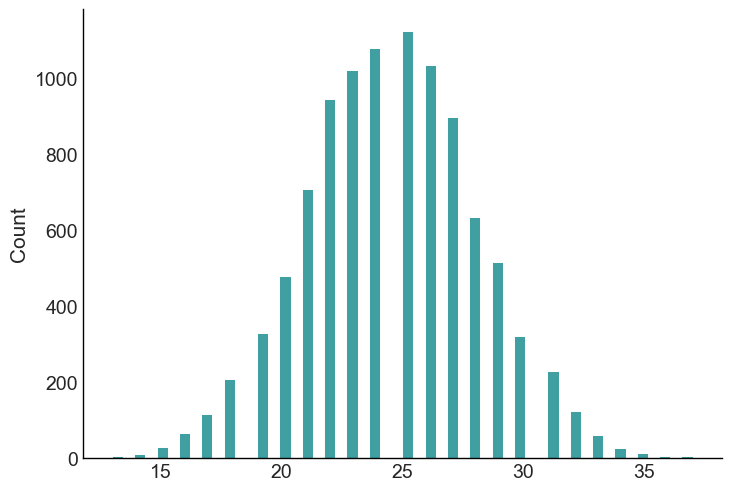

In [146]:
sample = dist.Binomial(total_count=jnp.sum(jnp.array(birth1) == 0), probs=0.5).sample(random.PRNGKey(100), (10000,))
counts = jnp.unique(sample, return_counts=True)

print(boys_after_female)
print(counts[0][jnp.argmax(counts[1])])

sns.histplot(sample)